# Part 1: Build the model in TensorFlow 1

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys
import urllib.request
import tarfile
import pickle
from time import time
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [2]:
dataset_url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
dataset_path='./datasets/cifar-10.tar.gz'
dataset_dir='./datasets/cifar-10-batches-py/'

if not os.path.exists(dataset_dir):
    if not os.path.isfile(dataset_path):
        result=urllib.request.urlretrieve(dataset_url,dataset_path)
        print('compressed dataset does not exist, downloading it now:',result)
        result=tarfile.open(dataset_path,'r:gz').extractall('datasets/')
        print('dataset has not been extracted, extracting it now...')
        os.remove(dataset_path)
    else: 
        print(dataset_path,'compressed dataset found!')
        result=tarfile.open(dataset_path,'r:gz').extractall('datasets/')
        print('dataset has not been extracted, extracting it now...')
        os.remove(dataset_path)
else:
    print('extracted dataset been found!')

extracted dataset been found!


In [3]:
def load_cifar_batch(cifar_batch_path):
    with open(cifar_batch_path,'rb')as cifar_batch:
        data_dict=pickle.load(cifar_batch,encoding='bytes')
        images=data_dict[b'data'].reshape(10000,3,32,32).transpose(0,2,3,1)
        labels=data_dict[b'labels']
        labels=np.array(labels)
        return images,labels
        
images_list=[]
labels_list=[]
for i in range(5):
    image_batch,label_batch=load_cifar_batch(os.path.join(dataset_dir,'data_batch_%d'%(i+1)))
    images_list.append(image_batch)
    labels_list.append(label_batch)
    train_images=np.concatenate(images_list)
    train_labels=np.concatenate(labels_list)
    del image_batch,label_batch
test_images,test_labels=load_cifar_batch(os.path.join(dataset_dir,'test_batch'))
print('finished loadding dataset')

finished loadding dataset


In [4]:
one_hot_encoder=OneHotEncoder(sparse=False)
one_hot_encoder.fit([[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]])

train_images=train_images.astype('float32')/255.0
test_images=test_images.astype('float32')/255.0
train_labels=train_labels.reshape(-1,1)
train_labels=one_hot_encoder.transform(train_labels)
test_labels=test_labels.reshape(-1,1)
test_labels=one_hot_encoder.transform(test_labels)

In [6]:
def weight(shape): return tf.Variable(tf.truncated_normal(shape=shape,stddev=0.1))
def bias(shape): return tf.Variable(tf.constant(0.1,shape=shape))
def conv2d(x,w): return tf.nn.conv2d(x,w,strides=[1,1,1,1],padding='SAME',use_cudnn_on_gpu=None)
def max_pool_2x2(x): return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

with tf.name_scope('input_layer'):
    x=tf.placeholder('float',shape=[None,32,32,3])
with tf.name_scope('conv_1'):
    w1=weight([3,3,3,32])
    b1=bias([32])
    conv_1=conv2d(x,w1)+b1
    conv_1=tf.nn.relu(conv_1)
with tf.name_scope('pool_1'):
    pool_1=max_pool_2x2(conv_1)
with tf.name_scope('conv_2'):
    w2=weight([3,3,32,64])
    b2=bias([64])
    conv_2=conv2d(pool_1,w2)+b2
    conv_2=tf.nn.relu(conv_2)
with tf.name_scope('pool_2'):
    pool_2=max_pool_2x2(conv_2)
with tf.name_scope('full_connect'):
    w3=weight([4096,128])
    b3=bias([128])
    flat=tf.reshape(pool_2,[-1,4096])
    h=tf.nn.relu(tf.matmul(flat,w3)+b3)
    h_dropout=tf.nn.dropout(h,keep_prob=0.8)
with tf.name_scope('output_layer'):
    w4=weight([128,10])
    b4=bias([10])
    pred=tf.nn.softmax(tf.matmul(h_dropout,w4)+b4)


In [8]:
with tf.name_scope('optimizer'):
    y=tf.placeholder('float',shape=[None,10])
    loss_function=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred,labels=y))
    optimizer=tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss_function)
with tf.name_scope('evaluation'):
    correct_prediction=tf.equal(tf.argmax(pred,1),tf.argmax(y,1))
    accuracy=tf.reduce_mean(tf.cast(correct_prediction,'float'))

In [7]:
startTime=time()
sess=tf.Session()
sess.run(tf.global_variables_initializer())

epoch_list=[]
acc_list=[]
loss_list=[]

train_epochs=10
batch_size=50
total_train_batch=int(len(train_images)/batch_size)
for epoch in range(train_epochs):
    for batch in range(total_train_batch):
        xs=train_images[batch*batch_size:(batch+1)*batch_size]
        ys=train_labels[batch*batch_size:(batch+1)*batch_size]
        sess.run(optimizer,feed_dict={x:xs,y:ys})
        if batch%200==0: print('epoch: {:02d} batch: {:03d}'.format(epoch+1,batch),'was just finished')
    loss,acc=sess.run([loss_function,accuracy],feed_dict={x:xs,y:ys})
    epoch_list.append(epoch+1)
    loss_list.append(loss)
    acc_list.append(acc)
    print('train epoch:{:02d}, loss={:.3f} ,accuracy={:.3f}'.format(epoch+1,loss,acc))
print('train finished takes:',time()-startTime)

epoch: 01 batch: 000 was just finished
epoch: 01 batch: 200 was just finished
epoch: 01 batch: 400 was just finished
epoch: 01 batch: 600 was just finished
epoch: 01 batch: 800 was just finished
train epoch:01, loss=2.203 ,accuracy=0.240
epoch: 02 batch: 000 was just finished
epoch: 02 batch: 200 was just finished
epoch: 02 batch: 400 was just finished
epoch: 02 batch: 600 was just finished
epoch: 02 batch: 800 was just finished
train epoch:02, loss=2.170 ,accuracy=0.280
epoch: 03 batch: 000 was just finished
epoch: 03 batch: 200 was just finished
epoch: 03 batch: 400 was just finished
epoch: 03 batch: 600 was just finished
epoch: 03 batch: 800 was just finished
train epoch:03, loss=2.131 ,accuracy=0.340
epoch: 04 batch: 000 was just finished
epoch: 04 batch: 200 was just finished
epoch: 04 batch: 400 was just finished
epoch: 04 batch: 600 was just finished
epoch: 04 batch: 800 was just finished
train epoch:04, loss=2.052 ,accuracy=0.460
epoch: 05 batch: 000 was just finished
epoch: 05

In [8]:
test_acc_sum=0
total_test_batch=int(len(test_images)/batch_size)
for batch in range(total_test_batch):
    xs=test_images[batch*batch_size:(batch+1)*batch_size]
    ys=test_labels[batch*batch_size:(batch+1)*batch_size]
    acc=sess.run(accuracy,feed_dict={x:xs,y:ys})
    test_acc_sum+=acc
print('test accuracy= {:.3f}'.format(test_acc_sum/total_test_batch))

test accuracy= 0.538


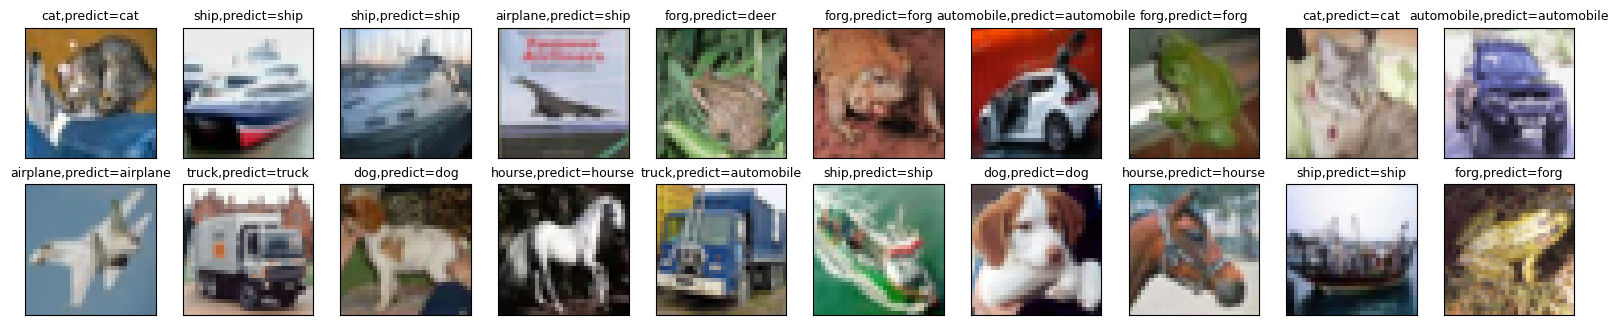

In [9]:
label_dict={0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'forg',7:'hourse',8:'ship',9:'truck'}

def plot_images_labels_prediction(images,labels,prediction,index,num=20):
    fig=plt.gcf()
    fig.set_size_inches(20,20)
    if num>100: num=100
    for i in range(0,num):
        ax=plt.subplot(10,10,i+1)
        ax.imshow(images[index],cmap='binary')
        title=label_dict[sess.run(tf.argmax(labels[index],0))]
        if len(prediction)>0:
            title+=',predict='+label_dict[sess.run(tf.argmax(prediction[index],0))]
        ax.set_title(title,fontsize=9)
        ax.set_xticks([])
        ax.set_yticks([])
        index+=1
    plt.show()

test_pred=sess.run(pred,feed_dict={x:test_images[:20]})
plot_images_labels_prediction(test_images,test_labels,test_pred,0,20)

# Part 2: Build the same model but in TensorFlow 2

In [10]:
sys.exit("The previous part of code finished execution. To run the following code, please 'Restart' and 'Run All' manually.")

SystemExit: The previous part of code finished execution. To run the following code, please 'Restart' and 'Run All' manually.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [2]:
cifar=tf.keras.datasets.cifar10
(train_images,train_labels),(test_images,test_labels)=cifar.load_data()

In [3]:
train_images=train_images.astype('float32')/255.0
test_images=test_images.astype('float32')/255.0

In [4]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),input_shape=(32,32,3),activation='relu',padding='same'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10,activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                    

In [5]:
class stop_training_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('accuracy')>0.8):
            print('\nModel accuracy is enough so training will stop')
            self.model.stop_training=True

callbacks=stop_training_callback()

In [6]:
train_epochs=100
batch_size=50
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
train_history=model.fit(train_images,train_labels,validation_split=0.2,epochs=train_epochs,batch_size=batch_size,verbose=2,callbacks=[callbacks])

Epoch 1/100
800/800 - 5s - loss: 1.4932 - accuracy: 0.4679 - val_loss: 1.3646 - val_accuracy: 0.5634 - 5s/epoch - 6ms/step
Epoch 2/100
800/800 - 1s - loss: 1.1602 - accuracy: 0.5930 - val_loss: 1.2010 - val_accuracy: 0.6101 - 1s/epoch - 1ms/step
Epoch 3/100
800/800 - 1s - loss: 1.0379 - accuracy: 0.6392 - val_loss: 1.1159 - val_accuracy: 0.6485 - 1s/epoch - 1ms/step
Epoch 4/100
800/800 - 1s - loss: 0.9684 - accuracy: 0.6646 - val_loss: 1.1127 - val_accuracy: 0.6241 - 1s/epoch - 1ms/step
Epoch 5/100
800/800 - 1s - loss: 0.9141 - accuracy: 0.6855 - val_loss: 1.0203 - val_accuracy: 0.6651 - 1s/epoch - 1ms/step
Epoch 6/100
800/800 - 1s - loss: 0.8716 - accuracy: 0.6965 - val_loss: 1.0067 - val_accuracy: 0.6751 - 1s/epoch - 1ms/step
Epoch 7/100
800/800 - 1s - loss: 0.8326 - accuracy: 0.7106 - val_loss: 0.9927 - val_accuracy: 0.6779 - 1s/epoch - 1ms/step
Epoch 8/100
800/800 - 1s - loss: 0.8069 - accuracy: 0.7171 - val_loss: 0.9315 - val_accuracy: 0.6972 - 996ms/epoch - 1ms/step
Epoch 9/100
8

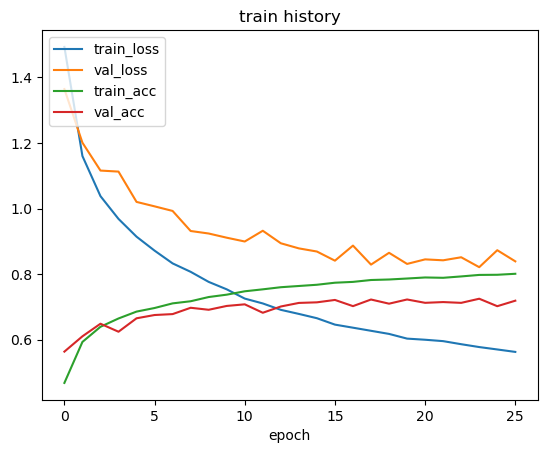

In [7]:
def show_train_history(train_history,train_loss,val_loss,train_acc,val_acc):
    plt.plot(train_history.history[train_loss])
    plt.plot(train_history.history[val_loss])
    plt.plot(train_history.history[train_acc])
    plt.plot(train_history.history[val_acc])
    plt.title('train history')
    plt.xlabel('epoch')
    plt.legend(['train_loss','val_loss','train_acc','val_acc'],loc='upper left')
    plt.show()

show_train_history(train_history,'loss','val_loss','accuracy','val_accuracy')

In [8]:
test_loss,test_acc=model.evaluate(test_images,test_labels,verbose=2)
print('test loss =',test_loss,',test accuracy =',test_acc)

313/313 - 0s - loss: 0.8516 - accuracy: 0.7176 - 344ms/epoch - 1ms/step
test loss = 0.8515533208847046 ,test accuracy = 0.7175999879837036
